<a href="https://colab.research.google.com/github/As2909/PRODIGY_ML_04/blob/main/Task_04_ML_Hand_Gesture_Recog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Download Dataset **

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F39466%2F61155%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240531%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240531T145251Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D106cd21494b8b50c7d173006d19c3c35fd8b44afde7c90bf17a04b598f02320a9763e25db29be6dcc1a4696e155ae5f4e55f785f6ef43c24cfb8607d6dee79385553dd3b26fa4327571bab2e475aab2c9b3e812e6ff6b75797fc11129195016518bbfac12e8b95768bbae2f7add93d41dd76b76e75c54fca6b5741e4b3e51254be9f5593ecdb0a34eaee55c255d83f7734fae9358db386c89636ce9a05fb9216cc6660688e9801d3ad78645448fb51da80066b63d9fc244ca7fc68247878283d4b906a7f31c694c413b1086e87a0fa5b9f43de7d3aedbceacab6b23cd6710dfe33f6961abd877e031800aed4f7507d30eb3f51f680147e3eda9f9772117802d3'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2286085038 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


**-------------------------------------------------------------------------------------------------------------------------------------------------------------**

In [1]:
import keras
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

from keras.layers import Conv2D, Activation, MaxPool2D, Dense, Flatten, Dropout

import warnings
warnings.filterwarnings('ignore')

In [2]:
CATEGORIES = ["01_palm", '02_l','03_fist','04_fist_moved','05_thumb','06_index','07_ok','08_palm_moved','09_c','10_down']
IMG_SIZE = 50

# paths for dataset
data_path = "../input/leapgestrecog/leapGestRecog"

**The Data**

In [3]:
# Loading the images and their class(0 - 9)
image_data = []
for dr in os.listdir(data_path):
    for category in CATEGORIES:
        class_index = CATEGORIES.index(category)
        path = os.path.join(data_path, dr, category)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                image_data.append([cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE)), class_index])
            except Exception as e:
                pass
image_data[0]

[array([[5, 4, 5, ..., 3, 3, 3],
        [4, 4, 5, ..., 2, 5, 4],
        [5, 4, 6, ..., 4, 4, 4],
        ...,
        [4, 4, 4, ..., 4, 4, 5],
        [5, 5, 4, ..., 4, 4, 5],
        [4, 4, 4, ..., 3, 4, 4]], dtype=uint8),
 0]

In [4]:
# shuffle the input data
import random
random.shuffle(image_data)

In [5]:
input_data = []
label = []
for X, y in image_data:
    input_data.append(X)
    label.append(y)

In [6]:
label[:10]

[2, 1, 9, 7, 7, 3, 9, 3, 0, 4]

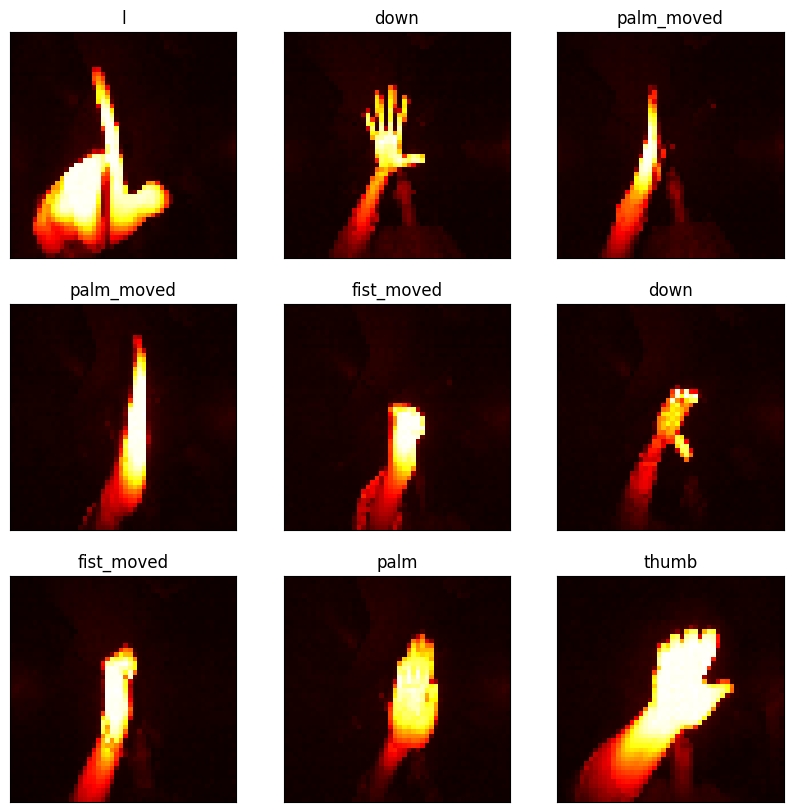

In [7]:
plt.figure(1, figsize=(10,10))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.imshow(image_data[i][0], cmap='hot')
    plt.xticks([])
    plt.yticks([])
    plt.title(CATEGORIES[label[i]][3:])
plt.show()

In [8]:
# Normalizing the data
input_data = np.array(input_data)
label = np.array(label)
input_data = input_data/255.0
input_data.shape

(20000, 50, 50)

In [9]:
# one hot encoding
label = keras.utils.to_categorical(label, num_classes=10,dtype='i1')
label[0]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

In [10]:
# reshaping the data
input_data.shape = (-1, IMG_SIZE, IMG_SIZE, 1)

In [11]:
# splitting the input_data to train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_data, label, test_size = 0.3, random_state=0)


**The Model**

In [12]:
model = keras.models.Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (IMG_SIZE, IMG_SIZE, 1)))
model.add(Activation('relu'))


model.add(Conv2D(filters = 32, kernel_size = (3,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (3,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer = 'rmsprop',
             metrics = ['accuracy'])

In [13]:
history = model.fit(X_train, y_train, epochs = 3, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/3
438/438 [==============================] - 118s 268ms/step - loss: 0.3617 - accuracy: 0.8799 - val_loss: 0.0138 - val_accuracy: 0.9967
Epoch 2/3
438/438 [==============================] - 115s 263ms/step - loss: 0.0194 - accuracy: 0.9942 - val_loss: 0.0051 - val_accuracy: 0.9992
Epoch 3/3
438/438 [==============================] - 128s 293ms/step - loss: 0.0081 - accuracy: 0.9974 - val_loss: 0.0056 - val_accuracy: 0.9988


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 46, 46, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 32)        0         
                                                        

In [15]:
# Print available keys in model.history.history
print(model.history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


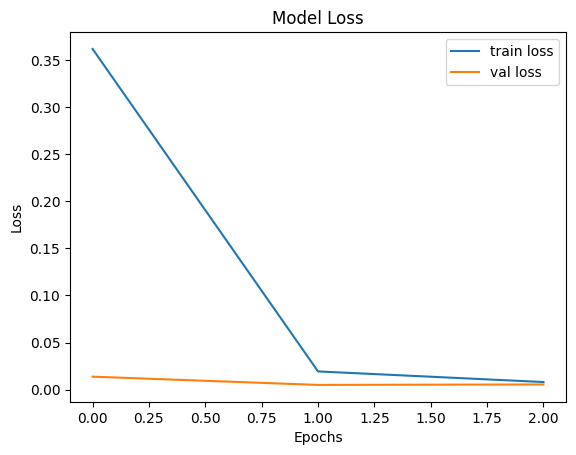

<Figure size 640x480 with 0 Axes>

In [16]:
# Plot the loss
from matplotlib import pyplot as plt

plt.plot(model.history.history["loss"], label = "train loss")
plt.plot(model.history.history["val_loss"], label ="val loss")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()
plt.savefig("LossVal_loss")

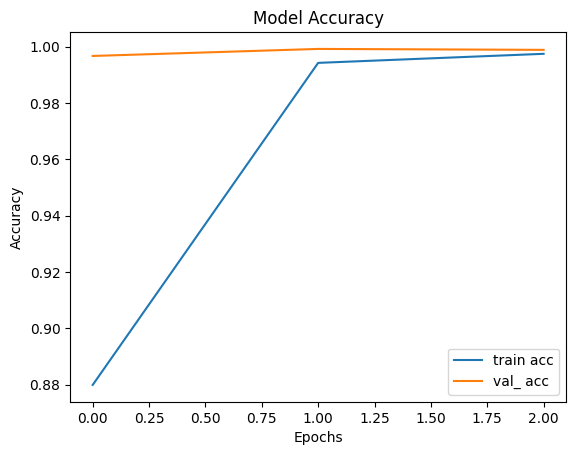

<Figure size 640x480 with 0 Axes>

In [17]:
# Plot the accuracy
plt.plot(model.history.history["accuracy"], label = "train acc")
plt.plot(model.history.history["val_accuracy"], label ="val_ acc")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()
plt.savefig("AccVal_acc")

In [18]:
#calculate loss and accuracy on test data

test_loss, test_accuracy = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_accuracy*100))

188/188 [==============================] - 12s 63ms/step - loss: 0.0056 - accuracy: 0.9988
Test accuracy: 99.88%
